In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from uuid import uuid4
import json

load_dotenv()

model= ChatOpenAI(model="gpt-4o")


In [2]:
search_tool= TavilySearchResults(max_results=4)

tools=[search_tool]
memory= MemorySaver()


response= await search_tool.ainvoke("When is the spaceX launch")
response

/var/folders/5c/rj4q3p_95m3b74t0bzy4hgyw0000gn/T/ipykernel_13906/2370642618.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool= TavilySearchResults(max_results=4)


[{'title': 'Space Launch Schedule & Live Videos: Stream Rockets Launches',
  'url': 'https://www.spacelaunchschedule.com/',
  'content': 'Go For Launch \n\n Wed • Aug 20th, 2025\n\n 5:13 PM UTC \n\n Baikonur Cosmodrome, Republic of Kazakhstan \n\n (USSF-36)Falcon 9 Block 5 ---------------------------------------\n### SpaceX\n\n Date/Time TBD \n\n Projected To Launch\n\n Thu • Aug 21st, 2025 \n\n Kennedy Space Center, FL, USA \n\n\n   Vulcan\n   New Glenn\n   New Shepard\n\n### View The Rocket Launch Schedule\n\n### By Location',
  'score': 0.86080295},
 {'title': "What time is SpaceX's Starship Flight 10 launch on Aug. 24?",
  'url': 'https://www.space.com/space-exploration/launches-spacecraft/spacex-starship-flight-10-launch-what-time',
  'content': "The Starship Flight 10 test is currently scheduled to launch on Sunday evening, Aug. 24, at 7:30 p.m. EDT (2300 GMT) from SpaceX's Starbase facility near Boca Chica Beach in South Texas. The launch could actually occur any time in a 60-mi

In [81]:
llm_with_tools= model.bind_tools(tools)

In [82]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result= await llm_with_tools.ainvoke(state["messages"])

    return {
        "messages": [result]
    }

async def tools_router(state: State):
    last_message= state["messages"][-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls :
        return "tool_node"
    else:
        return END

async def tool_node(state: State):
    """Custom tool node that handles tool calls from the LLM"""

    tool_calls= state["messages"][-1].tool_calls

    tool_messages=[]

    for tool_call in tool_calls:
        tool_name= tool_call["name"]
        tool_args= tool_call["args"]
        tool_id= tool_call["id"]

        if tool_name =="tavily_search_results_json" :

            search_results= search_tool.invoke(tool_args)

            tool_message= ToolMessage(
                content=str(search_results),
                tool_call_id= tool_id,
                name= tool_name
            )

            tool_messages.append(tool_message)
    
    return {
        "messages": tool_messages
    }

graph_builder= StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)

graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)

graph_builder.add_edge("tool_node", "model")

graph= graph_builder.compile(checkpointer=memory)    



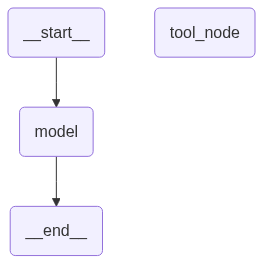

In [83]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [86]:
config={
    "configurable":{
        "thread_id": 5
    }
}

response= await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next SpaceX launch")]
}, config=config)

response

{'messages': [HumanMessage(content='What is current weather in Kolkata', additional_kwargs={}, response_metadata={}, id='d4c0bc16-94b0-480b-b4f2-1b9c42b1c9c9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Las3X71EyN5LTGh5lIcGYzwv', 'function': {'arguments': '{"query":"current weather in Kolkata"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 85, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_df0f7b956c', 'id': 'chatcmpl-C7iPZmmm3pa8DYaFeIyxSiYbiIhZp', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3d337550-0812-4bd8-88bd-ecc1c38ada1f-0', tool_calls=[{'name': 'tavily_search_r

In [88]:
config={
    "configurable":{
        "thread_id": 6
    }
}
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next SpaceX launch")]
}, config=config, version="v2"):
    if event["event"]=="on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

The next SpaceX launch is scheduled for July 30 at 03:30 UTC. This is for the Starlink (10-29) Mission using a Falcon 9 rocket from SLC-40 at Cape Canaveral Space Force Station in Florida, USA.